In [3]:
import sqlite3
import random
from datetime import datetime, timedelta

# Connexion à la base de données
conn = sqlite3.connect('ventesmagasin.db')
cursor = conn.cursor()

# Insertion de produits
produits = [
    (1, 'Laptop', 'Électronique', 999.99),
    (2, 'Smartphone', 'Électronique', 699.99),
    (3, 'Livre', 'Culture', 19.99),
    (4, 'Cafetière', 'Électroménager', 49.99),
    (5, 'T-shirt', 'Vêtements', 24.99)
]
cursor.executemany("INSERT INTO Produits VALUES (?, ?, ?, ?)", produits)

# Insertion de clients
clients = [
    (1, 'Alice Dupont', 'alice@example.com'),
    (2, 'Bob Martin', 'bob@example.com'),
    (3, 'Charlie Leroy', 'charlie@example.com'),
    (4, 'Diana Lambert', 'diana@example.com'),
    (5, 'Eve Moreau', 'eve@example.com')
]
cursor.executemany("INSERT INTO Clients VALUES (?, ?, ?)", clients)

# Insertion de ventes
for i in range(1, 101):
    id_produit = random.randint(1, 5)
    id_client = random.randint(1, 5)
    date_vente = (datetime(2023, 1, 1) + timedelta(days=random.randint(0, 364))).strftime('%Y-%m-%d')
    quantite = random.randint(1, 5)
    prix_unitaire = next(p[3] for p in produits if p[0] == id_produit)
    montant_total = quantite * prix_unitaire
    cursor.execute("INSERT INTO Ventes VALUES (?, ?, ?, ?, ?, ?)", 
                   (i, id_produit, id_client, date_vente, quantite, montant_total))

conn.commit()
conn.close()

IntegrityError: UNIQUE constraint failed: Produits.id_produit

In [5]:
import sqlite3
import pandas as pd

# Connexion à la base de données
conn = sqlite3.connect('ventesmagasin.db')

# Extraction des tables
produits_df = pd.read_sql_query("SELECT * FROM Produits;", conn)
clients_df = pd.read_sql_query("SELECT * FROM Clients;", conn)
ventes_df = pd.read_sql_query("SELECT * FROM Ventes;", conn)

# Jointure des données pour une vue complète
ventes_complet_df = pd.read_sql_query("""
    SELECT Ventes.*, Produits.nom_produit, Produits.categorie, Produits.prix_unitaire, 
           Clients.nom_client, Clients.email
    FROM Ventes
    JOIN Produits ON Ventes.id_produit = Produits.id_produit
    JOIN Clients ON Ventes.id_client = Clients.id_client
""", conn)

conn.close()

# Affichage des données
print(ventes_complet_df.head())

   id_vente  id_produit  id_client  date_vente  quantite  montant_total  \
0         1           4          5  2023-02-08         5         249.95   
1         2           3          1  2023-12-15         3          59.97   
2         3           3          2  2023-11-06         5          99.95   
3         4           5          5  2023-03-07         2          49.98   
4         5           5          4  2023-06-06         1          24.99   

  nom_produit       categorie  prix_unitaire     nom_client              email  
0   Cafetière  Électroménager          49.99     Eve Moreau    eve@example.com  
1       Livre         Culture          19.99   Alice Dupont  alice@example.com  
2       Livre         Culture          19.99     Bob Martin    bob@example.com  
3     T-shirt       Vêtements          24.99     Eve Moreau    eve@example.com  
4     T-shirt       Vêtements          24.99  Diana Lambert  diana@example.com  


In [6]:
import pandas as pd

# Chiffre d'affaires total
ca_total = ventes_df['montant_total'].sum()
print(f"Chiffre d'affaires total : {ca_total:.2f} €")

# Chiffre d'affaires moyen par vente
ca_moyen = ventes_df['montant_total'].mean()
print(f"Chiffre d'affaires moyen par vente : {ca_moyen:.2f} €")

# Top 5 des produits par quantité vendue
top_quantite = ventes_complet_df.groupby('nom_produit')['quantite'].sum().nlargest(5)
print("Top 5 des produits par quantité vendue :")
print(top_quantite)

# Top 5 des produits par chiffre d'affaires
top_ca = ventes_complet_df.groupby('nom_produit')['montant_total'].sum().nlargest(5)
print("Top 5 des produits par chiffre d'affaires :")
print(top_ca)

# Statistiques descriptives
print(ventes_df.describe())

Chiffre d'affaires total : 92626.77 €
Chiffre d'affaires moyen par vente : 926.27 €
Top 5 des produits par quantité vendue :
nom_produit
Livre         79
T-shirt       78
Cafetière     62
Smartphone    60
Laptop        44
Name: quantite, dtype: int64
Top 5 des produits par chiffre d'affaires :
nom_produit
Laptop        43999.56
Smartphone    41999.40
Cafetière      3099.38
T-shirt        1949.22
Livre          1579.21
Name: montant_total, dtype: float64
         id_vente  id_produit   id_client   quantite  montant_total
count  100.000000  100.000000  100.000000  100.00000     100.000000
mean    50.500000    3.250000    2.750000    3.23000     926.267700
std     29.011492    1.409742    1.459037    1.43446    1387.797524
min      1.000000    1.000000    1.000000    1.00000      19.990000
25%     25.750000    2.000000    1.000000    2.00000      74.970000
50%     50.500000    3.000000    3.000000    3.50000     124.950000
75%     75.250000    5.000000    4.000000    4.00000    1399.98000

/tmp/ipykernel_13867/1404214792.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ventes_par_mois = ventes_complet_df.groupby(pd.Grouper(key='date_vente', freq='M'))['montant_total'].sum()


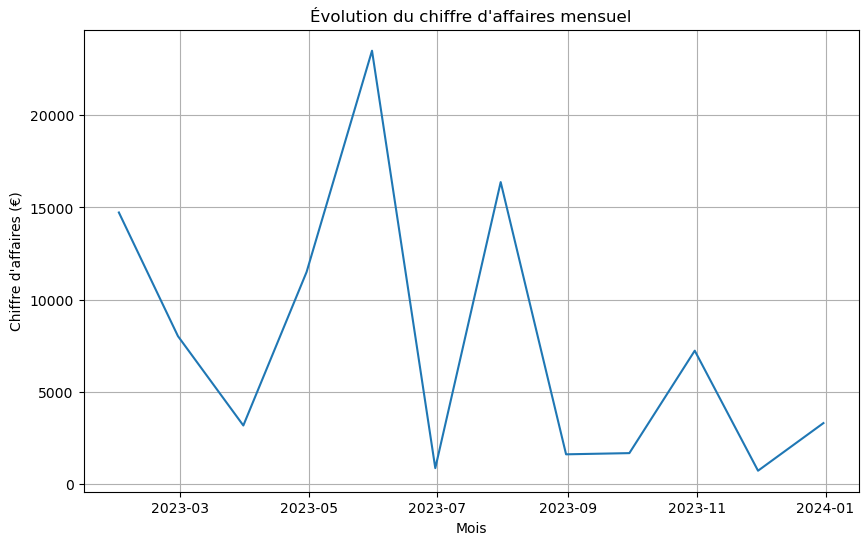

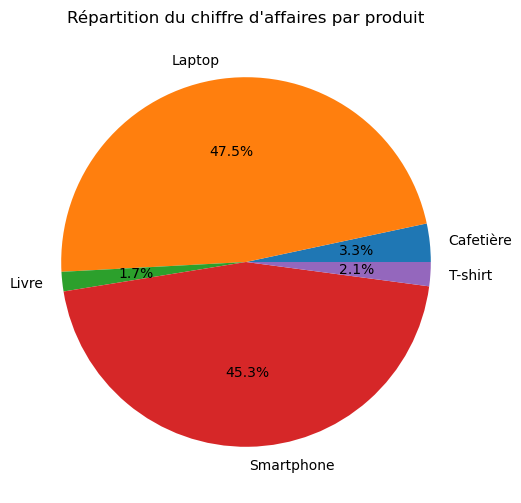

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Évolution temporelle des ventes
ventes_complet_df['date_vente'] = pd.to_datetime(ventes_complet_df['date_vente'])
ventes_par_mois = ventes_complet_df.groupby(pd.Grouper(key='date_vente', freq='M'))['montant_total'].sum()

plt.figure(figsize=(10, 6))
sns.lineplot(x=ventes_par_mois.index, y=ventes_par_mois.values)
plt.title("Évolution du chiffre d'affaires mensuel")
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaires (€)")
plt.grid()
plt.show()

# Répartition des ventes par produit
repartition_produits = ventes_complet_df.groupby('nom_produit')['montant_total'].sum()

plt.figure(figsize=(10, 6))
repartition_produits.plot.pie(autopct='%1.1f%%')
plt.title("Répartition du chiffre d'affaires par produit")
plt.ylabel("")
plt.show()